# Comparing methods of hurricane forecast uncertainty
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_ml_ats/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_ml_ats/blob/main/code/ann_uq_hurricanes.ipynb)

_Ongoing research by Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria_

We will be forecasting the error of the Consensus forecast (mean across multiple hurricane models) of hurricane intensity 72 hours in advance for hurricanes over the Eastern Pacific / Central Pacific. That is, our network will be used as a post-processing technique. Our input features (predictors) are composed of 11 variables that include information we think might be helpful, e.g. the models that went into the Consensus forecast, the environment (e.g. sea-surface temperature, shear), and the current latitude of the storm.

We will be predicting parameters of the conditional SHASH distribution for each prediction and then plotting these distributions.

## Initial import and module statements

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = False


In [2]:
import datetime
import os
import pickle
import pprint
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn import preprocessing
import tensorflow_probability as tfp
from tensorflow.keras import optimizers
from IPython.display import clear_output

from tqdm import tqdm
from numpy.random import default_rng


In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [4]:
import sys
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")  

python version = 3.7.11 (default, Jul 27 2021, 07:03:16) 
[Clang 10.0.0 ]
numpy version = 1.21.5
tensorflow version = 2.7.0


## Lots of predefined functions

### Plotting functions

In [5]:
def plot_history(history, model_name):
    """Plot the model.fit training history and save the resulting figure.

    Creates a 2-by-2 block of subplots.  The four plots are:
        1 -- training and validations loss history.
        2 -- training and validations customMAE history.
        3 -- training and validations InterquartileCapture history.
        4 -- training and validations SignTest history.

    Arguments
    ---------
    history : tf.keras.callbacks.History
        The history must have at least the following eight items
        in the history.history.keys()
            "loss",
            "val_loss",
            "custom_mae",
            "val_custom_mae",
            "interquartile_capture",
            "val_interquartile_capture",
            "sign_test",
            "val_sign_test"

    model_name : str
        The resulting figure is saved to:
            "figures/model_diagnostics/" + model_name + ".png"

    Returns
    -------
    None

    """
    TRAIN_COLOR = "#7570b3"
    VALID_COLOR = "#e7298a"
    FIGSIZE = (14, 10)
    FONTSIZE = 12
    DPIFIG = 300.0

    best_epoch = np.argmin(history.history["val_loss"])

    plt.figure(figsize=FIGSIZE)

    # Plot the training and validations loss history.
    plt.subplot(2, 2, 1)
    plt.plot(
        history.history["loss"],
        "o",
        color=TRAIN_COLOR,
        markersize=3,
        label="train",
    )

    plt.plot(
        history.history["val_loss"],
        "o",
        color=VALID_COLOR,
        markersize=3,
        label="valid",
    )

    plt.axvline(x=best_epoch, linestyle="--", color="tab:gray")
    plt.title("Log-likelihood Loss Function")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.legend(frameon=True, fontsize=FONTSIZE)

    # Plot the training and validations customMAE history.
    try:
        plt.subplot(2, 2, 2)
        plt.plot(
            history.history["custom_mae"],
            "o",
            color=TRAIN_COLOR,
            markersize=3,
            label="train",
        )
        plt.plot(
            history.history["val_custom_mae"],
            "o",
            color=VALID_COLOR,
            markersize=3,
            label="valid",
        )

        plt.axvline(x=best_epoch, linestyle="--", color="tab:gray")
        plt.title("Mean |true - median|")
        plt.xlabel("Epoch")
        plt.grid(True)
        plt.legend(frameon=True, fontsize=FONTSIZE)
    except:
        print('no mae metric, skipping plot')
        
    # Plot the training and validations InterquartileCapture history.
    try:
        plt.subplot(2, 2, 3)
        plt.plot(
            history.history["interquartile_capture"],
            "o",
            color=TRAIN_COLOR,
            markersize=3,
            label="train",
        )
        plt.plot(
            history.history["val_interquartile_capture"],
            "o",
            color=VALID_COLOR,
            markersize=3,
            label="valid",
        )

        plt.axvline(x=best_epoch, linestyle="--", color="tab:gray")
        plt.title("Fraction Between 25 and 75 Percentile")
        plt.xlabel("Epoch")
        plt.grid(True)
        plt.legend(frameon=True, fontsize=FONTSIZE)
    except:
        print('no interquartile_capture, skipping plot')

    # Plot the training and validations SignTest history.
    try:
        plt.subplot(2, 2, 4)
        plt.plot(
            history.history["sign_test"],
            "o",
            color=TRAIN_COLOR,
            markersize=3,
            label="train",
        )
        plt.plot(
            history.history["val_sign_test"],
            "o",
            color=VALID_COLOR,
            markersize=3,
            label="valid",
        )

        plt.axvline(x=best_epoch, linestyle="--", color="tab:gray")
        plt.title("Fraction Above the Median")
        plt.xlabel("Epoch")
        plt.grid(True)
        plt.legend(frameon=True, fontsize=FONTSIZE)
    except:
        print('no sign-test, skipping plot')

    # Draw and save the plot.
    plt.tight_layout()
    # plt.savefig("figures/model_diagnostics/" + model_name + ".png", dpi=DPIFIG)
    plt.show()

class TrainingInstrumentation(tf.keras.callbacks.Callback):
    """Plot real-time training instrumentation panel.

    If x_data and onehot_data are not given, the instrumentation panel
    includes only the real-time plot of the training and validation loss.

    If the x_data and onehot_data are given, the instrumentation panel also
    includes the PIT histogram plot, and histogram plots for each of the
    local conditional distribution parameters, updated in real time.

    Parameters
    ----------
    x_data : tensor, default=None
        The x_train (or x_valid) tensor.  If either x_data or onehot_data
        is specifed, then both must be specified and they must have the
        same number of rows.

    onehot_data : tensor, default=None
        The onehot_train (or onehot_valid) tensor. If either x_data or
        onehot_data is specifed, then both must be specified and they must
        have the same number of rows.

    figsize: (float, float), default=(13, 7)
        Size of the instrumentation panel.

    interval: int, default=1
        Number of epochs (steps) between refreshing the instruments.  By
        default, interval=1, and the intruments are updated ever epoch.

    Usage
    -----
    * Include TrainingInstrumentation() as a callback in model.fit; e.g.

        training_callback = TrainingInstrumentation(
            x_train_std, onehot_train, interval=10
        )
        ...
        history = model.fit(
            ...
            callbacks=[training_callback],
        )

    Notes
    -----
    * This Class is explcitly designed for the SHASH distribution, with
        parameter names 'mu', 'sigma', 'gamma', and 'tau'.

    """

    def __init__(
        self,
        x_data=None,
        onehot_data=None,
        figsize=(13, 7),
        interval=1,
    ):
        super().__init__()
        self.x_data = x_data
        self.onehot_data = onehot_data
        self.figsize = figsize
        self.interval = interval

    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs={}):
        self.loss.append(logs.get("loss"))
        self.val_loss.append(logs.get("val_loss"))

        if epoch % self.interval == 0:
            clear_output(wait=True)
            plt.figure(figsize=self.figsize)

            best_epoch = np.argmin(self.val_loss)
            plt.subplot(3, 2, 1)
            plt.plot(self.loss, "o", color="#7570b3", label="train", markersize=2)
            plt.plot(self.val_loss, "o", color="#e7298a", label="valid", markersize=2)
            plt.axvline(x=best_epoch, linestyle="--", color="gray")
            plt.title(f"Loss After {epoch} Epochs")
            plt.grid(True)
            plt.legend(
                [
                    f"train = {logs.get('loss'):.3f}",
                    f"valid = {logs.get('val_loss'):.3f}",
                ]
            )

            if (self.x_data is not None) and (self.onehot_data is not None):
                preds = self.model.predict(self.x_data)

                if preds.shape[1] >= 1:
                    mu = preds[:, 0]
                    plt.subplot(3, 2, 3)
                    plt.hist(mu, bins=30, color="#7fc97f", edgecolor="k")
                    plt.legend(["mu"])

                if preds.shape[1] >= 2:
                    # sigma = tf.math.exp(preds[:, 1])
                    sigma = preds[:, 1]
                    plt.subplot(3, 2, 4)
                    plt.hist(sigma, bins=30, color="#beaed4", edgecolor="k")
                    plt.legend(["sigma"])
                else:
                    sigma = tf.zeros_like(mu)

                if preds.shape[1] >= 3:
                    gamma = preds[:, 2]
                    plt.subplot(3, 2, 5)
                    plt.hist(gamma, bins=30, color="#fdc086", edgecolor="k")
                    plt.legend(["gamma"])
                else:
                    gamma = tf.zeros_like(mu)

                if preds.shape[1] >= 4:
                    # tau = tf.math.exp(preds[:, 3])
                    tau = preds[:, 3]
                    plt.subplot(3, 2, 6)
                    plt.hist(tau, bins=30, color="#ffff99", edgecolor="k")
                    plt.legend(["tau"])
                else:
                    tau = tf.ones_like(mu)

                F = shash_cdf(self.onehot_data[:, 0], mu, sigma, gamma, tau)
                plt.subplot(3, 2, 2)
                plt.hist(
                    F.numpy(),
                    bins=np.linspace(0, 1, 21),
                    color="#386cb0",
                    edgecolor="k",
                )
                plt.legend(["PIT"])
                plt.axhline(y=F.shape[0] / 20, color="b", linestyle="--")

            plt.show()

In [6]:
def params(x_inputs, model):
    """Funtion to make shash parameter predictions for shash2, shash3, shash4

    Arguments
    ---------
    x_inputs : floats
        matrix of inputs to the network

    model : tensorflow model
        neural network for predictions

    Returns
    -------
    vector of predicted parameters

    """
    y_pred = model.predict(x_inputs)
    mu_pred = y_pred[:, 0]
    sigma_pred = y_pred[:, 1]

    gamma_pred = np.zeros(np.shape(y_pred[:, 0]),dtype='float32')
    if np.shape(y_pred)[1] == 3:
        gamma_pred = y_pred[:, 2]

    tau_pred = np.ones(np.shape(y_pred[:, 0]),dtype='float32')
    if np.shape(y_pred)[1] == 4:
        tau_pred = y_pred[:, 3]

    return mu_pred, sigma_pred, gamma_pred, tau_pred


def percentile_value(mu_pred, sigma_pred, gamma_pred, tau_pred, percentile_frac=0.5):
    """Function to obtain percentile value of the shash distribution."""
    return shash_quantile(
        pr=percentile_frac, mu=mu_pred, sigma=sigma_pred, gamma=gamma_pred, tau=tau_pred
    ).numpy()

### Metrics and loss functions / scalings

In [7]:
class Exponentiate(keras.layers.Layer):
    """Custom layer to exp the sigma and tau estimates inline."""

    def __init__(self, **kwargs):
        super(Exponentiate, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.math.exp(inputs)

class InterquartileCapture(tf.keras.metrics.Metric):
    """Compute the fraction of true values between the 25 and 75 percentiles.

    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.count = self.add_weight("count", initializer="zeros")
        self.total = self.add_weight("total", initializer="zeros")

    def update_state(self, y_true, pred, sample_weight=None):
        mu = pred[:, 0]
        sigma = pred[:, 1]

        if pred.shape[1] >= 3:
            gamma = pred[:, 2]
        else:
            gamma = tf.zeros_like(mu)

        if pred.shape[1] >= 4:
            tau = pred[:, 3]
        else:
            tau = tf.ones_like(mu)

        lower = shash_quantile(0.25, mu, sigma, gamma, tau)
        upper = shash_quantile(0.75, mu, sigma, gamma, tau)

        batch_count = tf.reduce_sum(
            tf.cast(
                tf.math.logical_and(
                    tf.math.greater(y_true[:, 0], lower),
                    tf.math.less(y_true[:, 0], upper)
                ),
                tf.float32
            )

        )
        batch_total = len(y_true[:, 0])

        self.count.assign_add(tf.cast(batch_count, tf.float32))
        self.total.assign_add(tf.cast(batch_total, tf.float32))

    def result(self):
        return self.count / self.total

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}


class SignTest(tf.keras.metrics.Metric):
    """Compute the fraction of true values above the median.

    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.count = self.add_weight("count", initializer="zeros")
        self.total = self.add_weight("total", initializer="zeros")

    def update_state(self, y_true, pred, sample_weight=None):
        mu = pred[:, 0]
        sigma = pred[:, 1]

        if pred.shape[1] >= 3:
            gamma = pred[:, 2]
        else:
            gamma = tf.zeros_like(mu)

        if pred.shape[1] >= 4:
            tau = pred[:, 3]
        else:
            tau = tf.ones_like(mu)

        median = shash_median(mu, sigma, gamma, tau)

        batch_count = tf.reduce_sum(
            tf.cast(tf.math.greater(y_true[:, 0], median), tf.float32)
        )
        batch_total = len(y_true[:, 0])

        self.count.assign_add(tf.cast(batch_count, tf.float32))
        self.total.assign_add(tf.cast(batch_total, tf.float32))

    def result(self):
        return self.count / self.total

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

    
class CustomMAE(tf.keras.metrics.Metric):
    """Compute the prediction mean absolute error.

    The "predicted value" is the median of the conditional distribution.

    Notes
    -----
    * The computation is done by maintaining running sums of total predictions
        and correct predictions made across all batches in an epoch. The
        running sums are reset at the end of each epoch.

    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.error = self.add_weight("error", initializer="zeros")
        self.total = self.add_weight("total", initializer="zeros")

    def update_state(self, y_true, pred, sample_weight=None):
        mu = pred[:, 0]
        sigma = pred[:, 1]

        if pred.shape[1] >= 3:
            gamma = pred[:, 2]
        else:
            gamma = tf.zeros_like(mu)

        if pred.shape[1] >= 4:
            tau = pred[:, 3]
        else:
            tau = tf.ones_like(mu)

        predictions = shash_median(mu, sigma, gamma, tau)

        error = tf.math.abs(y_true[:, 0] - predictions)
        batch_error = tf.reduce_sum(error)
        batch_total = tf.math.count_nonzero(error)

        self.error.assign_add(tf.cast(batch_error, tf.float32))
        self.total.assign_add(tf.cast(batch_total, tf.float32))

    def result(self):
        return self.error / self.total

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}
   
    
def compute_NLL(y, distr): 
    return -distr.log_prob(y) 

def compute_shash_NLL(y_true, pred):
    """Negative log-likelihood loss using the sinh-arcsinh normal distribution.

    Arguments
    ---------
    y_true : tensor
        The ground truth values.
        shape = [batch_size, n_parameter]

    pred :
        The predicted local conditionsal distribution parameter values.
        shape = [batch_size, n_parameters]

    Returns
    -------
    loss : tensor, shape = [1, 1]
        The average negative log-likelihood of the batch using the predicted
        conditional distribution parameters.

    Notes
    -----
    * The value of n_parameters depends on the chosen form of the conditional
        sinh-arcsinh normal distribution.
            shash2 -> n_parameter = 2, i.e. mu, sigma
            shash3 -> n_parameter = 3, i.e. mu, sigma, gamma
            shash4 -> n_parameter = 4, i.e. mu, sigma, gamma, tau

    * Since sigma and tau must be strictly positive, the network learns the
        log of these two parameters.

    * If gamma is not learned (i.e. shash2), they are set to 0.

    * If tau is not learned (i.e. shash2 or shash3), they are set to 1.

    """
    mu = pred[:, 0]
    sigma = pred[:, 1]

    if pred.shape[1] >= 3:
        gamma = pred[:, 2]
    else:
        gamma = tf.zeros_like(mu)

    if pred.shape[1] >= 4:
        tau = pred[:, 3]
    else:
        tau = tf.ones_like(mu)

    loss = -shash_log_prob(y_true[:, 0], mu, sigma, gamma, tau)
    return tf.reduce_mean(loss, axis=-1)


### Define and compute the SHASH distribution

In [8]:
"""sinh-arcsinh normal distribution w/o using tensorflow_probability.

Functions
---------
cdf(x, mu, sigma, gamma, tau=None)
    cumulative distribution function (cdf).

log_prob(x, mu, sigma, gamma, tau=None)
    log of the probability density function.

mean(mu, sigma, gamma, tau=None)
    distribution mean.

median(mu, sigma, gamma, tau=None)
    distribution median.

prob(x, mu, sigma, gamma, tau=None)
    probability density function (pdf).

quantile(pr, mu, sigma, gamma, tau=None)
    inverse cumulative distribution function.

rvs(mu, sigma, gamma, tau=None, size=1)
    generate random variates.

stddev(mu, sigma, gamma, tau=None)
    distribution standard deviation.

variance(mu, sigma, gamma, tau=None)
    distribution variance.

Notes
-----
* This module uses only tensorflow.  This module does not use the
tensorflow_probability library.

* The sinh-arcsinh normal distribution was defined in [1]. A more accessible
presentation is given in [2]. 

* The notation and formulation used in this code was taken from [3], page 143.
In the gamlss.dist/CRAN package the distribution is called SHASHo. 

* There is a typographical error in the presentation of the probability 
density function on page 143 of [3]. There is an extra "2" in the denomenator
preceeding the "sqrt{1 + z^2}" term.

References
----------
[1] Jones, M. C. & Pewsey, A., Sinh-arcsinh distributions,
Biometrika, Oxford University Press, 2009, 96, 761-780.
DOI: 10.1093/biomet/asp053.

[2] Jones, C. & Pewsey, A., The sinh-arcsinh normal distribution,
Significance, Wiley, 2019, 16, 6-7.
DOI: 10.1111/j.1740-9713.2019.01245.x.
https://rss.onlinelibrary.wiley.com/doi/10.1111/j.1740-9713.2019.01245.x

[3] Stasinopoulos, Mikis, et al. (2021), Distributions for Generalized 
Additive Models for Location Scale and Shape, CRAN Package.
https://cran.r-project.org/web/packages/gamlss.dist/gamlss.dist.pdf

"""
import numpy as np
import scipy
import scipy.stats
import tensorflow as tf

__author__ = "Randal J. Barnes and Elizabeth A. Barnes"
__date__ = "14 January 2022"


SQRT_TWO = 1.4142135623730950488016887
ONE_OVER_SQRT_TWO = 0.7071067811865475244008444
TWO_PI = 6.2831853071795864769252868
SQRT_TWO_PI = 2.5066282746310005024157653
ONE_OVER_SQRT_TWO_PI = 0.3989422804014326779399461


def _jones_pewsey_P(q):
    """P_q function from page 764 of [1].

    Arguments
    ---------
    q : float, array like

    Returns
    -------
    P_q : array like of same shape as q.

    Notes
    -----
    * The formal equation is

            jp = 0.25612601391340369863537463 * (
                scipy.special.kv((q + 1) / 2, 0.25) +
                scipy.special.kv((q - 1) / 2, 0.25)
            )

        The strange constant 0.25612... is "sqrt( sqrt(e) / (8*pi) )" computed
        with a high-precision calculator.  The special function

            scipy.special.kv

        is the Modified Bessel function of the second kind: K(nu, x).

    * But, we cannot use the scipy.special.kv function during tensorflow
        training.  This code uses a 6th order polynomial approximation in
        place of the formal function.

    * This approximation is well behaved for 0 <= q <= 10. Since q = 1/tau
        or q = 2/tau in our applications, the approximation is well behaved
        for 1/10 <= tau < infty.

    """
    # A 6th order polynomial approximation of log(_jones_pewsey_P) for the
    # range 0 <= q <= 10.  Over this range, the max |error|/true < 0.0025.
    # These coefficients were computed by minimizing the maximum relative
    # error, and not by a simple least squares regression.
    coeffs = [
        9.37541380598926e-06,
        -0.000377732651131894,
        0.00642826706073389,
        -0.061281078712518,
        0.390956214318641,
        -0.0337884356755193,
        0.00248824801827172
    ]
    return tf.math.exp(tf.math.polyval(coeffs, q))


def shash_cdf(x, mu, sigma, gamma, tau=None):
    """Cumulative distribution function (cdf).

    Parameters
    ----------
    x : float (batch size x 1) Tensor
        The values at which to compute the probability density function.

    mu : float (batch size x 1) Tensor
        The location parameter. Must be the same shape as x.

    sigma : float (batch size x 1) Tensor
        The scale parameter. Must be strictly positive. Must be the same
        shape as x.

    gamma : float (batch size x 1) Tensor
        The skewness parameter. Must be the same shape as x.

    tau : float (batch size x 1) Tensor or None
        The tail-weight parameter. Must be strictly positive. Must be the same
        shape as x. If tau is None then the default value of tau=1 is used.

    Returns
    -------
    F : float (batch size x 1) Tensor.
        The computed cumulative probability distribution function (cdf)
        evaluated at the values of x.  F has the same shape as x.

    Notes
    -----
    * This function uses the tensorflow.math.erf function rather than the
    tensorflow_probability normal distribution functions.

    """
    y = (x - mu) / sigma    
    
    if tau is None:
        z = tf.math.sinh(tf.math.asinh(y) - gamma)
    else:
        z = tf.math.sinh(tau * tf.math.asinh(y) - gamma)

    return 0.5 * (1.0 + tf.math.erf(ONE_OVER_SQRT_TWO * z))


def shash_log_prob(x, mu, sigma, gamma, tau=None):
    """Log-probability density function.

    Parameters
    ----------
    x : float (batch size x 1) Tensor
        The values at which to compute the probability density function.

    mu : float (batch size x 1) Tensor
        The location parameter. Must be the same shape as x.

    sigma : float (batch size x 1) Tensor
        The scale parameter. Must be strictly positive. Must be the same
        shape as x.

    gamma : float (batch size x 1) Tensor
        The skewness parameter. Must be the same shape as x.

    tau : float (batch size x 1) Tensor
        The tail-weight parameter. Must be strictly positive. Must be the same
        shape as x. If tau is None then the default value of tau=1 is used.

    Returns
    -------
    f : float (batch size x 1) Tensor.
        The natural logarithm of the computed probability density function
        evaluated at the values of x.  f has the same shape as x.

    Notes
    -----
    * This function is included merely to emulate the tensorflow_probability
    distributions.

    """
    return tf.math.log(shash_prob(x, mu, sigma, gamma, tau))


def shash_mean(mu, sigma, gamma, tau=None):
    """The distribution mean.

    Arguments
    ---------
    mu : float (batch size x 1) Tensor
        The location parameter.

    sigma : float (batch size x 1) Tensor
        The scale parameter. Must be strictly positive. Must be the same
        shape as mu.

    gamma : float (batch size x 1) Tensor
        The skewness parameter. Must be the same shape as mu.

    tau : float (batch size x 1) Tensor
        The tail-weight parameter. Must be strictly positive. Must be the same
        shape as mu. If tau is None then the default value of tau=1 is used.

    Returns
    -------
    x : float (batch size x 1) Tensor.
        The computed distribution mean values.

    Notes
    -----
    * This equation for evX can be found on page 764 of [1].

    """
    if tau is None:
        evX = tf.math.sinh(gamma) * 1.35453080648132  
    else:
        evX = tf.math.sinh(gamma / tau) * _jones_pewsey_P(1.0 / tau)

    return mu + sigma * evX


def shash_median(mu, sigma, gamma, tau=None):
    """The distribution median.

    Arguments
    ---------
    mu : float (batch size x 1) Tensor
        The location parameter.

    sigma : float (batch size x 1) Tensor
        The scale parameter. Must be strictly positive. Must be the same
        shape as mu.

    gamma : float (batch size x 1) Tensor
        The skewness parameter. Must be the same shape as mu.

    tau : float (batch size x 1) Tensor
        The tail-weight parameter. Must be strictly positive. Must be the same
        shape as mu. If tau is None then the default value of tau=1 is used.

    Returns
    -------
    x : float (batch size x 1) Tensor.
        The computed distribution mean values.

    Notes
    -----
    * This code uses the basic formula:

        E(a*X + b) = a*E(X) + b

    * The E(X) is computed using the moment equation given on page 764 of [1].

    """
    if tau is None:
        return mu + sigma * tf.math.sinh(gamma)
    else:
        return mu + sigma * tf.math.sinh(gamma / tau)


def shash_prob(x, mu, sigma, gamma, tau=None):
    """Probability density function (pdf).

    Parameters
    ----------
    x : float (batch size x 1) Tensor
        The values at which to compute the probability density function.

    mu : float (batch size x 1) Tensor
        The location parameter. Must be the same shape as x.

    sigma : float (batch size x 1) Tensor
        The scale parameter. Must be strictly positive. Must be the same
        shape as x.

    gamma : float (batch size x 1) Tensor
        The skewness parameter. Must be the same shape as x.

    tau : float (batch size x 1) Tensor
        The tail-weight parameter. Must be strictly positive. Must be the same
        shape as x. If tau is None then the default value of tau=1 is used.

    Returns
    -------
    f : float (batch size x 1) Tensor.
        The computed probability density function evaluated at the values of x.
        f has the same shape as x.

    Notes
    -----
    * This code uses the equations on page 143 of [3], and the associated
    notation.

    """
    y = (x - mu) / sigma
    
    if tau is None:
        rsqr = tf.math.square(tf.math.sinh(tf.math.asinh(y) - gamma))
        return (
            ONE_OVER_SQRT_TWO_PI
            / sigma
            * tf.math.sqrt((1 + rsqr) / (1 + tf.math.square(y)))
            * tf.math.exp(-rsqr / 2)
        )
        
    else:
        rsqr = tf.math.square(tf.math.sinh(tau * tf.math.asinh(y) - gamma))
        return (
            ONE_OVER_SQRT_TWO_PI
            * (tau / sigma)
            * tf.math.sqrt((1 + rsqr) / (1 + tf.math.square(y)))
            * tf.math.exp(-rsqr / 2)
        )


def shash_quantile(pr, mu, sigma, gamma, tau=None):
    """Inverse cumulative distribution function.

    Arguments
    ---------
    pr : float (batch size x 1) Tensor.
        The probabilities at which to compute the values.

    mu : float (batch size x 1) Tensor
        The location parameter. Must be the same shape as pr.

    sigma : float (batch size x 1) Tensor
        The scale parameter. Must be strictly positive. Must be the same
        shape as pr.

    gamma : float (batch size x 1) Tensor
        The skewness parameter. Must be the same shape as pr.

    tau : float (batch size x 1) Tensor
        The tail-weight parameter. Must be strictly positive. Must be the same
        shape as pr. If tau is None then the default value of tau=1 is used.

    Returns
    -------
    x : float (batch size x 1) Tensor.
        The computed values at the specified probabilities. f has the same
        shape as pr.

    """
    z = tf.math.ndtri(pr)
            
    if tau is None:
        return mu + sigma * tf.math.sinh(tf.math.asinh(z) + gamma)    
    else:
        return mu + sigma * tf.math.sinh((tf.math.asinh(z) + gamma) / tau)


def shash_rvs(mu, sigma, gamma, tau=None, size=1):
    """Generate an array of random variates.

    Arguments
    ---------
    mu : float or double scalar
        The location parameter.

    sigma : float or double scalar
        The scale parameter. Must be strictly positive.

    gamma : float or double scalar
        The skewness parameter.

    tau : float or double scalar, or None
        The tail-weight parameter. Must be strictly positive. 
        If tau is None then the default value of tau=1 is used.

    size : int or tuple of ints, default=1.
        The number of random variates.

    Returns
    -------
    x : double ndarray of size=size
        The generated random variates.

    """
    z = scipy.stats.norm.rvs(size=size)
    
    if tau is None:
        return mu + sigma * np.sinh(np.arcsinh(z) + gamma)
    else:
        return mu + sigma * np.sinh((np.arcsinh(z) + gamma) / tau)


def shash_stddev(mu, sigma, gamma, tau=None):
    """The distribution standard deviation.

    Arguments
    ---------
    mu : float (batch size x 1) Tensor
        The location parameter.

    sigma : float (batch size x 1) Tensor
        The scale parameter. Must be strictly positive. Must be the same
        shape as mu.

    gamma : float (batch size x 1) Tensor
        The skewness parameter. Must be the same shape as mu.

    tau : float (batch size x 1) Tensor
        The tail-weight parameter. Must be strictly positive. Must be the same
        shape as mu. If tau is None then the default value of tau=1 is used.

    Returns
    -------
    x : float (batch size x 1) Tensor.
        The computed distribution standard deviation values.

    """
    return tf.math.sqrt(variance(mu, sigma, gamma, tau))


def shash_variance(mu, sigma, gamma, tau=None):
    """The distribution variance.

    Arguments
    ---------
    mu : float (batch size x 1) Tensor
        The location parameter.

    sigma : float (batch size x 1) Tensor
        The scale parameter. Must be strictly positive. Must be the same
        shape as mu.

    gamma : float (batch size x 1) Tensor
        The skewness parameter. Must be the same shape as mu.

    tau : float (batch size x 1) Tensor
        The tail-weight parameter. Must be strictly positive. Must be the same
        shape as mu. If tau is None then the default value of tau=1 is used.

    Returns
    -------
    x : float (batch size x 1) Tensor.
        The computed distribution variance values.

    Notes
    -----
    * This code uses two basic formulas:

        var(X) = E(X^2) - (E(X))^2
        var(a*X + b) = a^2 * var(X)

    * The E(X) and E(X^2) are computed using the moment equations given on
    page 764 of [1].

    """
    if tau is None:
        evX = tf.math.sinh(gamma) * 1.35453080648132
        evX2 = (tf.math.cosh(2 * gamma) * 3.0 - 1.0) / 2
    else:
        evX = tf.math.sinh(gamma / tau) * _jones_pewsey_P(1.0 / tau)
        evX2 = (tf.math.cosh(2 * gamma / tau) * _jones_pewsey_P(2.0 / tau) - 1.0) / 2
        
    return tf.math.square(sigma) * (evX2 - tf.math.square(evX))

### Build the SHASH tf model

In [9]:
def make_model(settings, x_train, onehot_train, model_compile=False):
    if settings["uncertainty_type"][:5] == "shash":   
        model = build_shash_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
            dropout_rate=settings["dropout_rate"],
            rng_seed=settings["rng_seed"],                    
        )

        if model_compile == True:        
            model.compile(
                optimizer=optimizers.SGD(
                    learning_rate=settings["learning_rate"],
                    momentum=settings["momentum"],
                    nesterov=settings["nesterov"],
                ),
                loss=compute_shash_NLL,
                metrics=[
                    CustomMAE(name="custom_mae"),
                    InterquartileCapture(name="interquartile_capture"),
                    SignTest(name="sign_test"),
                ],
            )
    else:
        raise NotImplementedError
    
    return model
    
def build_shash_model(
    x_train, onehot_train, hiddens, output_shape, ridge_penalty=[0.0,], act_fun="relu", rng_seed=999, dropout_rate=[0.0,],
):
    """Build the fully-connected shash network architecture with
    internal scaling.

    Arguments
    ---------
    x_train : numpy.ndarray
        The training split of the x data.
        shape = [n_train, n_features].

    onehot_train : numpy.ndarray
        The training split of the scaled y data is in the first column.
        The remaining columns are filled with zeros. The number of columns
        equal the number of distribution parameters.
        shape = [n_train, n_parameters].

    hiddens : list (integers)
        Numeric list containing the number of neurons for each layer.

    output_shape : integer {2, 3, 4}
        The number of distribution output parameters to be learned.

    ridge_penalty : float, default=0.0
        The L2 regularization penalty for the first layer.

    act_fun : function, default="relu"
        The activation function to use on the deep hidden layers.

    Returns
    -------
    model : tensorflow.keras.models.Model

    Notes
    -----
    * The number of output units is determined by the output_shape argument.
        If output_shape is:
        2 -> output_layer = [mu_unit, sigma_unit]
        3 -> output_layer = [mu_unit, sigma_unit, gamma_unit]
        4 -> output_layer = [mu_unit, sigma_unit, gamma_unit, tau_unit]

    * Unlike most of EAB's models, the features are normalized within the
        network.  That is, the x_train, y_train, ... y_test should not be
        externally normalized or scaled.

    * In essence, the network is learning the shash parameters for the
        normalized y values. Say mu_z and sigma_z where

            z = (y - y_avg)/y_std

        The mu_unit and sigma_unit layers rescale the learned mu_z
        and sigma_z parameters back to the dimensions of the y values.
        Specifically,

            mu_y    = y_std * mu_z + y_avg
            sigma_y = y_std * sigma_z

        However, since the model works with log(sigma) we must use

            log(sigma_y) = log(y_std * sigma_z) = log(y_std) + log(sigma_z)

    * Note the gamma and tau parameters of the shash distribution are
        dimensionless by definition. So we do not need to rescale gamma
        and tau.

    """
    # set inputs
    if len(hiddens) != len(ridge_penalty):
        ridge_penalty = np.ones(np.shape(hiddens))*ridge_penalty
    if len(hiddens) != len(dropout_rate):
        dropout_rate = np.ones((len(hiddens)+1,))*dropout_rate
    
    # The avg and std for feature normalization are computed from x_train.
    # Using the .adapt method, these are set once and do not change, but
    # the constants travel with the model.
    inputs = tf.keras.Input(shape=x_train.shape[1:])

    normalizer = tf.keras.layers.Normalization()
    normalizer.adapt(x_train)
    x = normalizer(inputs)
    
    x = tf.keras.layers.Dropout(
        rate=dropout_rate[0],
        seed=rng_seed,            
    )(x)        

    # linear network only
    if hiddens[0] == 0:
        x = tf.keras.layers.Dense(
            units=1,
            activation="linear",
            use_bias=True,
            kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=ridge_penalty[0]),
            bias_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed+0),
            kernel_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed+0),
        )(x)
    else:
        # Initialize the first hidden layer.
        x = tf.keras.layers.Dense(
            units=hiddens[0],
            activation=act_fun,
            use_bias=True,
            kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=ridge_penalty[0]),
            bias_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed+0),
            kernel_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed+0),
        )(x)

        # Initialize the subsequent hidden layers.
        for ilayer, layer_size in enumerate(hiddens[1:]):
            
            x = tf.keras.layers.Dropout(
                rate=dropout_rate[ilayer+1],
                seed=rng_seed,            
            )(x)            
            
            x = tf.keras.layers.Dense(
                units=layer_size,
                activation=act_fun,
                use_bias=True,
                kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=ridge_penalty[ilayer+1]),
                bias_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed+ilayer+1),
                kernel_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed+ilayer+1),
            )(x)
            
    # final dropout prior to output layer
    x = tf.keras.layers.Dropout(
        rate=dropout_rate[-1],
        seed=rng_seed,            
    )(x) 
            
    # Compute the mean and standard deviation of the y_train data to rescale
    # the mu and sigma parameters.
    y_avg = np.mean(onehot_train[:, 0])
    y_std = np.std(onehot_train[:, 0])

    # mu_unit.  The network predicts the scaled mu_z, then the resclaing
    # layer scales it up to mu_y.
    mu_z_unit = tf.keras.layers.Dense(
        units=1,
        activation="linear",
        use_bias=True,
        bias_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed+100),
        kernel_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed+100),
        name="mu_z_unit",
    )(x)

    mu_unit = tf.keras.layers.Rescaling(
        scale=y_std,
        offset=y_avg,
        name="mu_unit",
    )(mu_z_unit)

    # sigma_unit. The network predicts the log of the scaled sigma_z, then
    # the resclaing layer scales it up to log of sigma y, and the custom
    # Exponentiate layer converts it to sigma_y.
    log_sigma_z_unit = tf.keras.layers.Dense(
        units=1,
        activation="linear",
        use_bias=True,
        bias_initializer=tf.keras.initializers.Zeros(),
        kernel_initializer=tf.keras.initializers.Zeros(),
        name="log_sigma_z_unit",
    )(x)

    log_sigma_unit = tf.keras.layers.Rescaling(
        scale=1.0,
        offset=np.log(y_std),
        name="log_sigma_unit",
    )(log_sigma_z_unit)

    sigma_unit = Exponentiate(
        name="sigma_unit",
    )(log_sigma_unit)

    # Add gamma and tau units if requested.
    if output_shape == 2:
        output_layer = tf.keras.layers.concatenate([mu_unit, sigma_unit], axis=1)

    else:
        # gamma_unit. The network predicts the gamma directly.
        gamma_unit = tf.keras.layers.Dense(
            units=1,
            activation="linear",
            use_bias=True,
            bias_initializer=tf.keras.initializers.Zeros(),
            kernel_initializer=tf.keras.initializers.Zeros(),
            name="gamma_unit",
        )(x)

        if output_shape == 3:
            output_layer = tf.keras.layers.concatenate(
                [mu_unit, sigma_unit, gamma_unit], axis=1
            )

        else:
            # tau_unit. The network predicts the log of the tau, then
            # the custom Exponentiate layer converts it to tau.
            log_tau_unit = tf.keras.layers.Dense(
                units=1,
                activation="linear",
                use_bias=True,
                bias_initializer=tf.keras.initializers.Zeros(),
                kernel_initializer=tf.keras.initializers.Zeros(),
                name="log_tau_unit",
            )(x)

            tau_unit = Exponentiate(
                name="tau_unit",
            )(log_tau_unit)

            if output_shape == 4:
                output_layer = tf.keras.layers.concatenate(
                    [mu_unit, sigma_unit, gamma_unit, tau_unit], axis=1
                )
            else:
                raise NotImplementedError

    model = tf.keras.models.Model(inputs=inputs, outputs=output_layer)
    return model


## Train the network

### Get the data

In [10]:
import pickle
if IN_COLAB:
    # !pip install wget
    import wget
    filename = wget.download("https://raw.githubusercontent.com/eabarnes1010/course_ml_ats/main/data/EPCP72_data.pickle")        
else:
    filename = '../data/EPCP72_data.pickle'

with open(filename,'rb') as f:
     data = pickle.load(f)
        
(   data_summary,
    x_train,
    onehot_train,
    x_val,
    onehot_val,
    x_test,
    onehot_test,    
    df_train,
    df_val,
    df_test,
) = data

print('data is loaded')

data is loaded


### Train the model

In [11]:
# ------------ MODIFY ------------
# many of the parameters below are things that you can easily modify

settings = {
        "filename": "nnfit_vlist_intensity_and_track_extended.dat",
        "uncertainty_type": 'shash3',  # OPTIONS: "shash2", "shash4"  
        "leadtime": 72,
        "basin": "EP|CP",
        "target": "intensity",
        "undersample": False,
        "hiddens": [15, 10],
        "dropout_rate": [0.,0.,0.],
        "ridge_param": [0.0,0.0],            
        "learning_rate": 0.0001,
        "momentum": 0.9,
        "nesterov": True,
        "batch_size": 64,
        "rng_seed": 888,
        "act_fun": "relu",
        "n_epochs": 25_000,
        "patience": 100,
        "test_condition": (2018,),
        "val_condition": "random",
        "n_val": 256,
        "n_train": "max",               
    }

2022-03-21 06:07:20.244564: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 normalization (Normalization)  (None, 11)           23          ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 11)           0           ['normalization[0][0]']          
                                                                                                  
 dense (Dense)                  (None, 15)           180         ['dropout[0][0]']                
                                                                                              

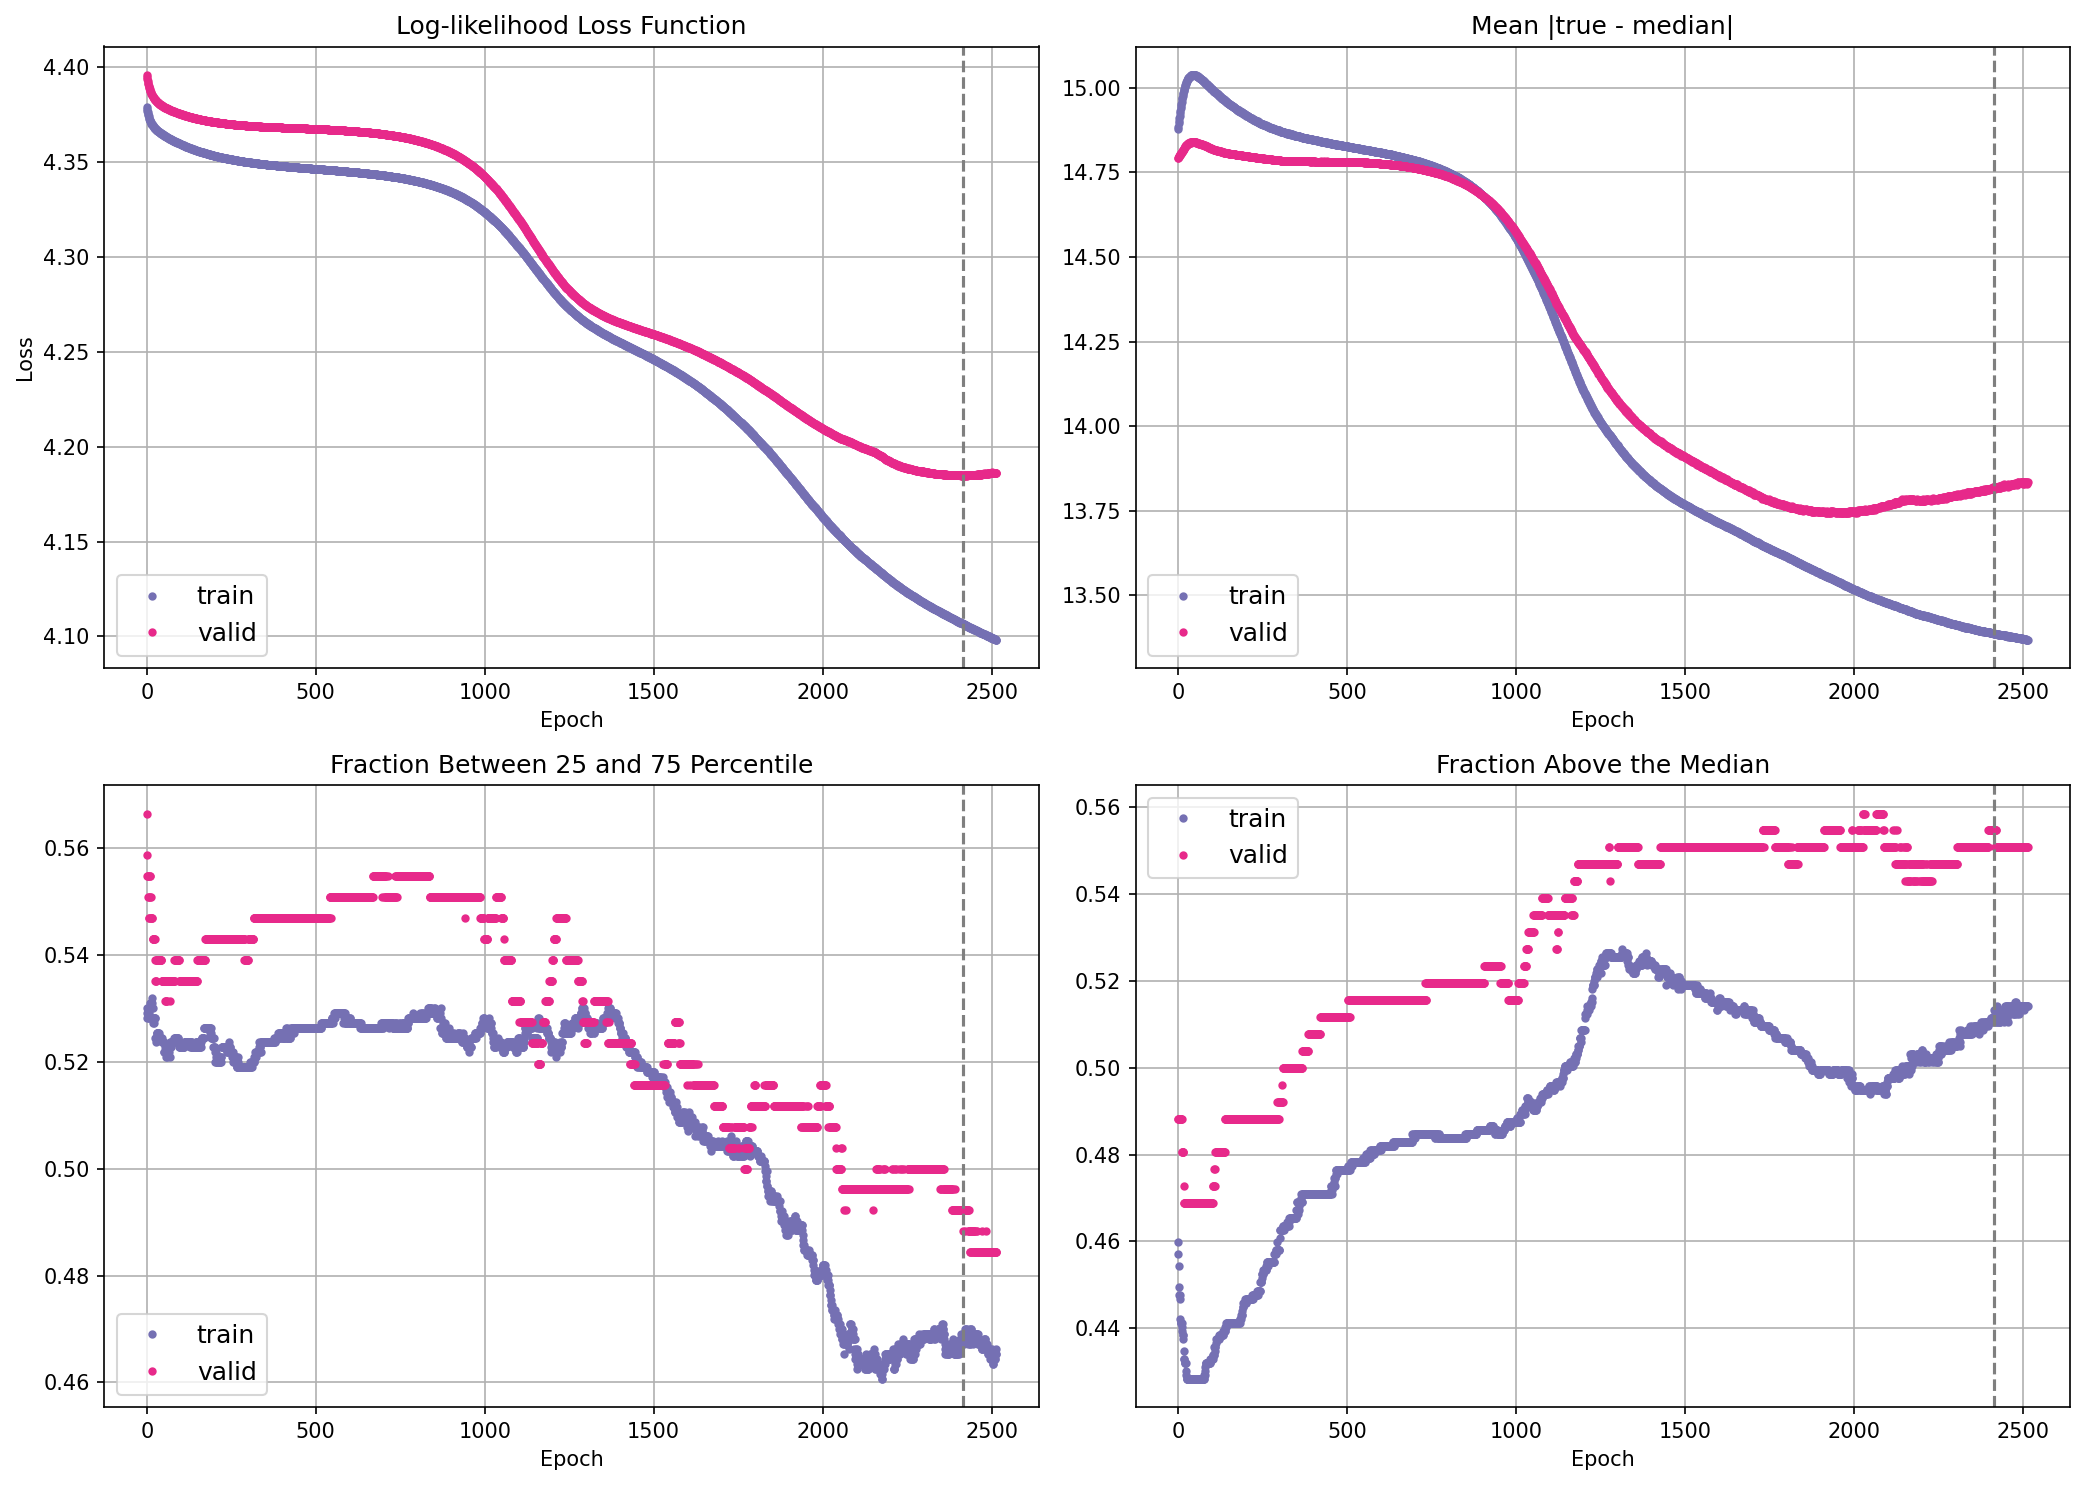

In [12]:
# define the callbacks
earlystoping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=settings["patience"],
    restore_best_weights=True,
    verbose=1,
)

training_callback = TrainingInstrumentation(
    x_train,
    onehot_train,
    interval=50,
)

callbacks = [earlystoping_callback, 
            #  training_callback,  # uncomment if you want to see the training stats updated
            ]

# set network seed and train the model
NETWORK_SEED_LIST = [settings["rng_seed"]]

for network_seed in NETWORK_SEED_LIST:
    tf.random.set_seed(network_seed)  # This sets the global random seed.

    # Make, compile, and train the model
    tf.keras.backend.clear_session()            
    model = make_model(
        settings,
        x_train,
        onehot_train,
        model_compile=True,
    )   
    model.summary()

    # train the network
    start_time = time.time()
    history = model.fit(
        x_train,
        onehot_train,
        validation_data=(x_val, onehot_val),
        batch_size=settings["batch_size"],
        epochs=settings["n_epochs"],
        shuffle=True,
        verbose=0,
        callbacks=callbacks,
    )
    stop_time = time.time()

    # Display the results, and save the model rum.
    best_epoch = np.argmin(history.history["val_loss"])
    fit_summary = {
        "network_seed": network_seed,
        "elapsed_time": stop_time - start_time,
        "best_epoch": best_epoch,
        "loss_train": history.history["loss"][best_epoch],
        "loss_valid": history.history["val_loss"][best_epoch],
    }
    pprint.pprint(fit_summary, width=80)
    plot_history(history, 'class example')


## Plot the predicted distributions

### Plotting functions

In [43]:
clr_shash = 'teal'
clr_bnn   = 'orange'
clr_truth = 'dimgray'

### for white background...
plt.rc('text',usetex=False)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')


def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([])  

def plot_sample(ax, onehot_val, shash_incs, shash_cpd, sample=130):
    plt.sca(ax)  

    if(shash_cpd.shape[0]<sample):
        sample = shash_cpd.shape[0]-1
    
    bins = np.arange(np.min(shash_incs),np.max(shash_incs)+2,2)

    # results for SHASH
    plt.plot(shash_incs,
             shash_cpd[sample,:],
             color=clr_shash,
             linewidth=4,
             label='SHASH',
            )

    # truth
    plt.axvline(x=onehot_val[sample,0],color=clr_truth,linestyle='--', label='Actual / Label')

    plt.legend()

    ax = plt.gca()
    xticks = ax.get_xticks()
    yticks = np.around(ax.get_yticks(),3)
    plt.xticks(xticks.astype(int),xticks.astype(int))
    plt.yticks(yticks,yticks)

    plt.title('Sample ' + str(sample),fontsize=16)
    plt.xlabel('predicted deviation from consensus (knots)')
    plt.ylabel('probability density function')    

### Compute the predicted distributions

First we need to evaluate and create the PDFs for the predicted parameters - otherwise, we would just be plotting the predicted parameters of the SHASH.

In [38]:
x_eval = x_test
onehot_eval = onehot_test
    
shash_incs = np.arange(-160,161,1)
shash_cpd = np.zeros((np.shape(x_eval)[0],len(shash_incs)))
shash_med = np.zeros((np.shape(x_eval)[0],))

# loop through samples for shash calculation and get PDF for each sample
for j in tqdm(range(0,np.shape(shash_cpd)[0])):
    mu_pred, sigma_pred, gamma_pred, tau_pred = params( x_eval[np.newaxis,j], model )
    shash_cpd[j,:] = shash_prob(shash_incs, mu_pred, sigma_pred, gamma_pred, tau_pred)    
    shash_med[j]   = shash_median(mu_pred,sigma_pred,gamma_pred,tau_pred)
    

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:11<00:00, 26.17it/s]


### Make plots of multiple samples

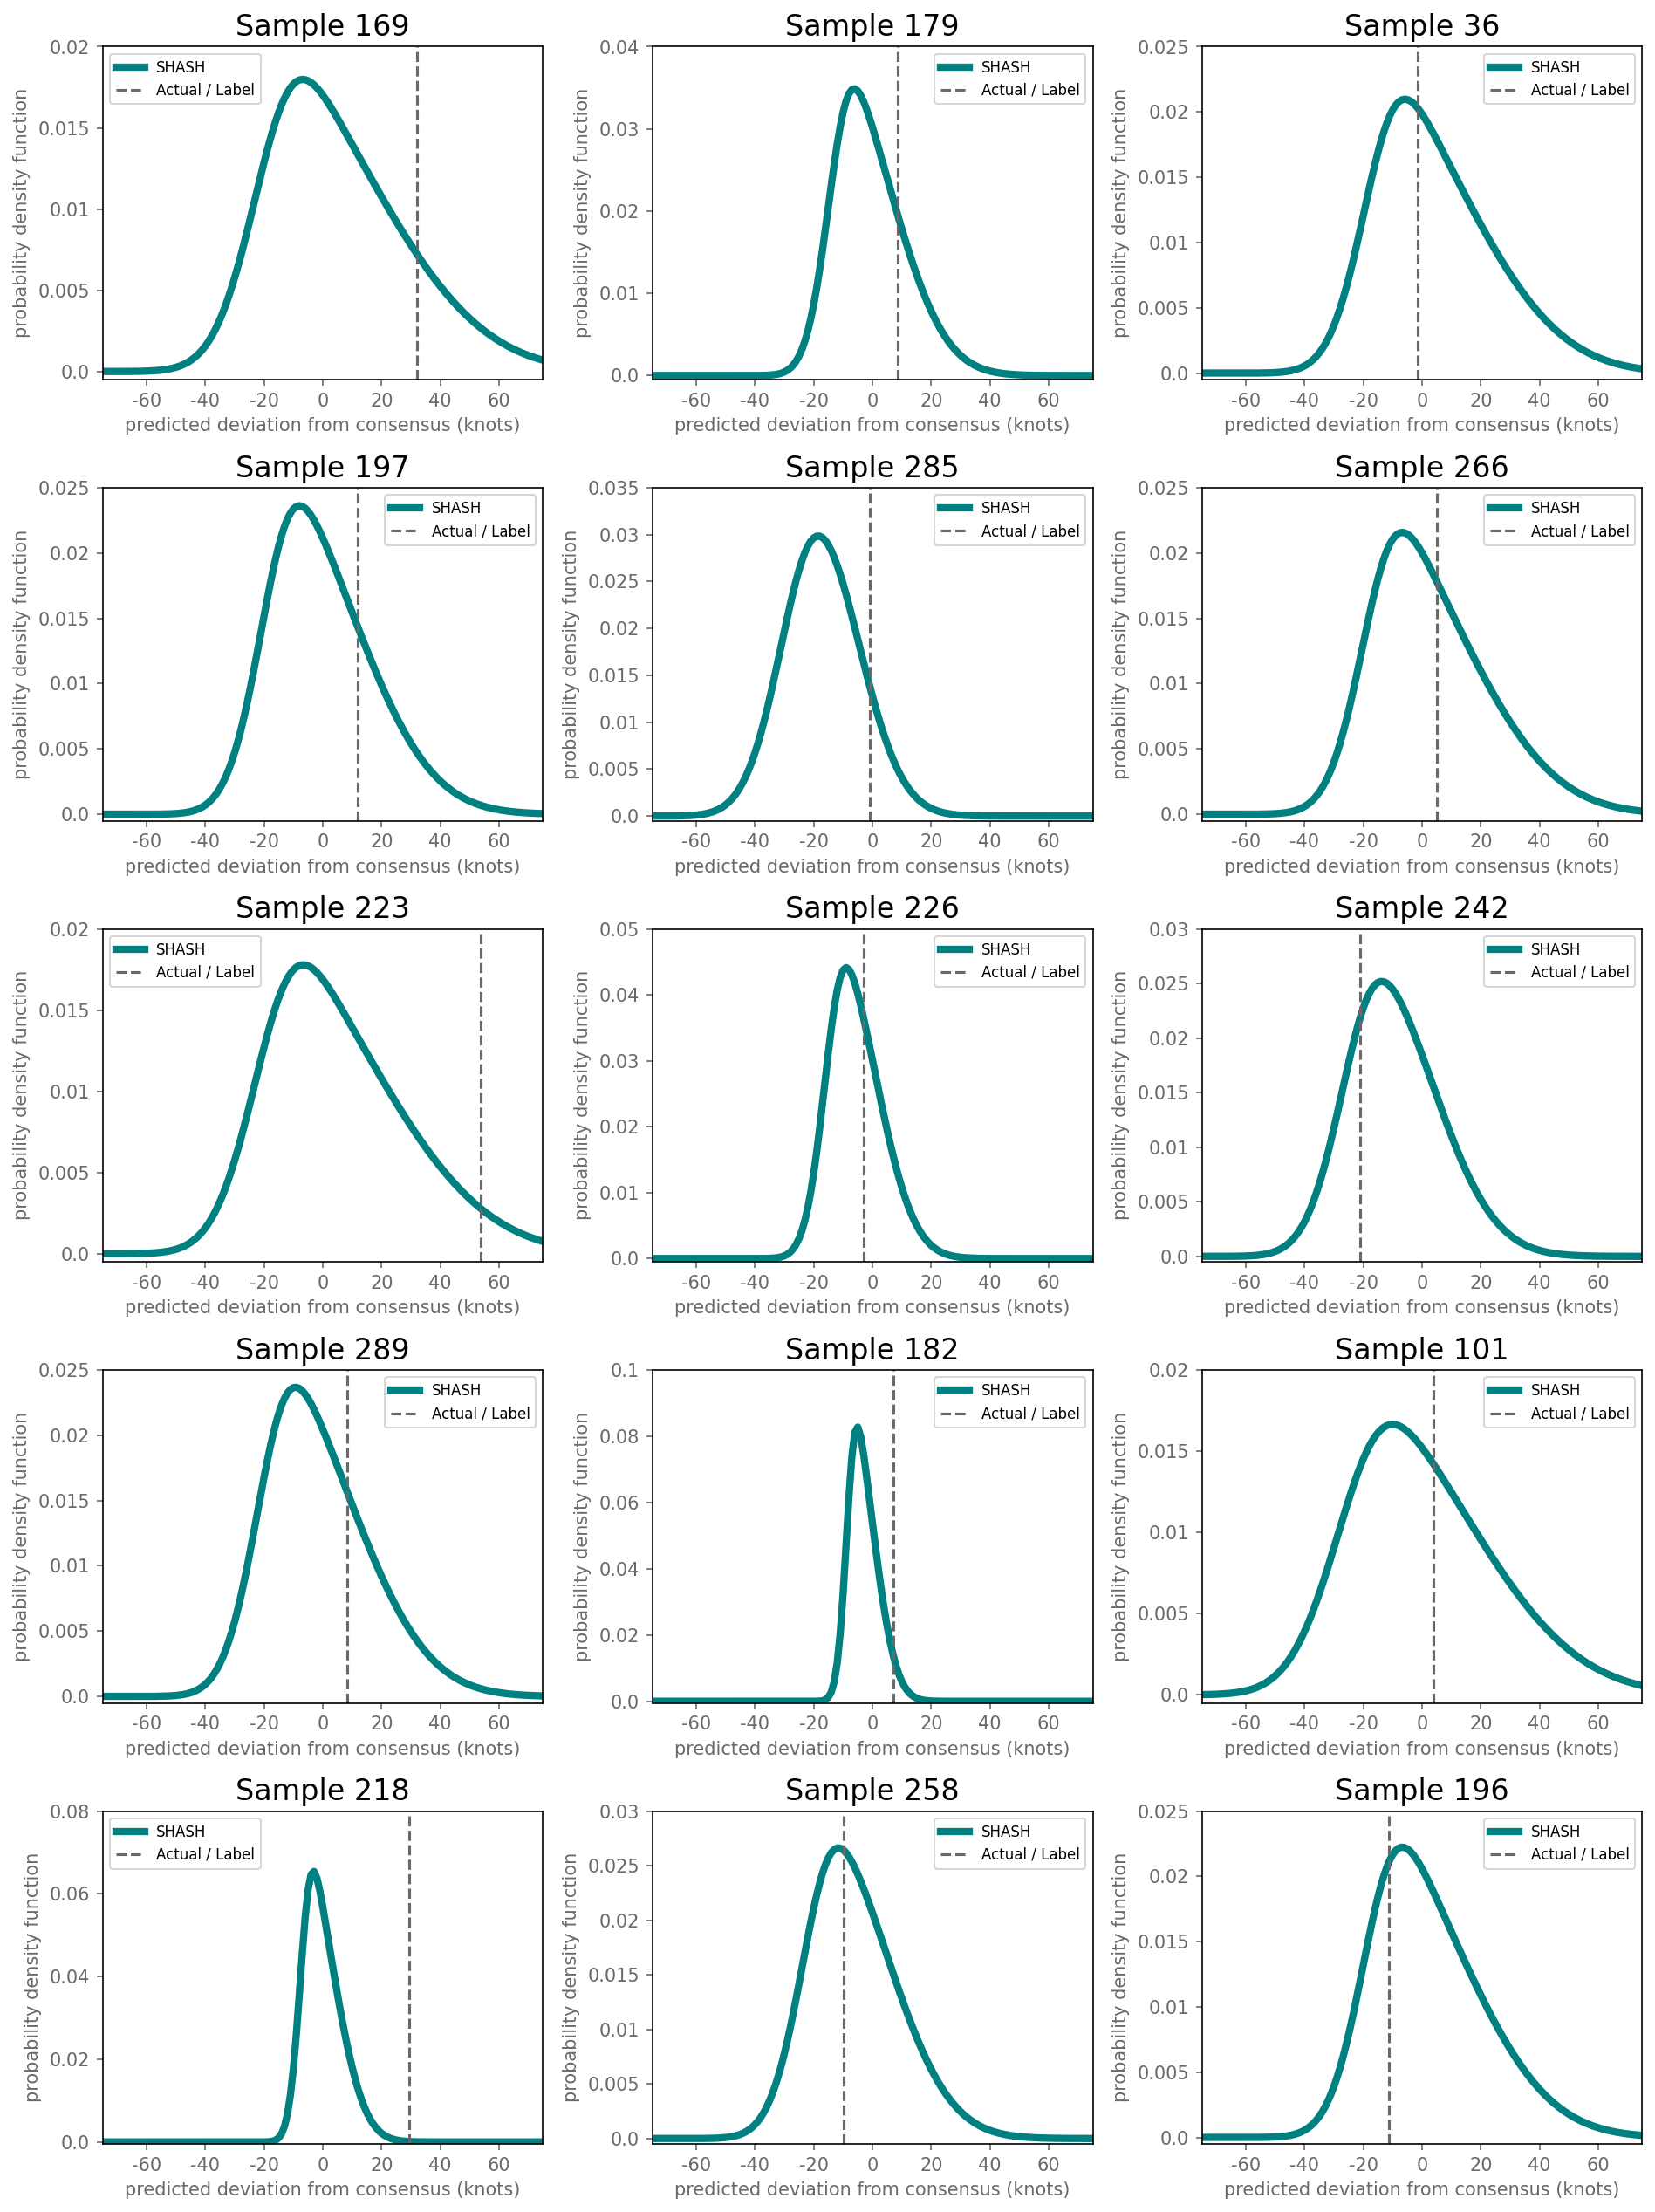

In [44]:
f, axs = plt.subplots(5, 3, figsize=(15*.85,20*.85))
axs = axs.flatten()
random_samples = rng.choice(np.arange(0,onehot_eval.shape[0]),len(axs),replace=False)

for isample, sample in enumerate(random_samples):
    ax = axs[isample]
    plot_sample(ax, onehot_eval, shash_incs, shash_cpd, sample=sample)

    ax.set_xticks(np.arange(-200,200,20),np.arange(-200,200,20))    
    ax.set_xlim(-75,75)
    ax.legend(fontsize=8)
    ax.set_ylim(-0.0005,None)
plt.tight_layout()
plt.show()        